In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq

In [ ]:
# Check working directory
import os
os.getcwd()

In [3]:
# Set working directory to where the files are
new_directory = "../output-XETG00127__0010466__top__20240119__022444_4754"
os.chdir(new_directory)

In [7]:
adata = sc.read_10x_h5("cell_feature_matrix.h5")
df = pd.read_csv("cells.csv")
df.set_index(adata.obs_names, inplace=True)
adata.obs = df.copy()
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

In [61]:
# Subset data to region of interest
# Create a boolean mask based on spatial coordinates
x_min = 1500
x_max = 5000
y_min = 1000
y_max = 3000

criteria = (
    (adata.obs['x_centroid'] >= x_min) & (adata.obs['x_centroid'] <= x_max) &
    (adata.obs['y_centroid'] >= y_min) & (adata.obs['y_centroid'] <= y_max)
)
# Subset the AnnData object based on the spatial criteria
subset_adata = adata[criteria, :]

In [66]:
# CALCULATING QC METRICS
sc.pp.calculate_qc_metrics(subset_adata, percent_top=(10, 20, 50, 150), inplace=True)

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


In [67]:
cprobes = (
    subset_adata.obs["control_probe_counts"].sum() / subset_adata.obs["total_counts"].sum() * 100
)
cwords = (
    subset_adata.obs["control_codeword_counts"].sum() / subset_adata.obs["total_counts"].sum() * 100
)
print(f"Negative DNA probe count % : {cprobes}")
print(f"Negative decoding count % : {cwords}")

Negative DNA probe count % : 0.0015019993488832822
Negative decoding count % : 0.002666048844267826


/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

<Axes: title={'center': 'Nucleus ratio'}, ylabel='Count'>

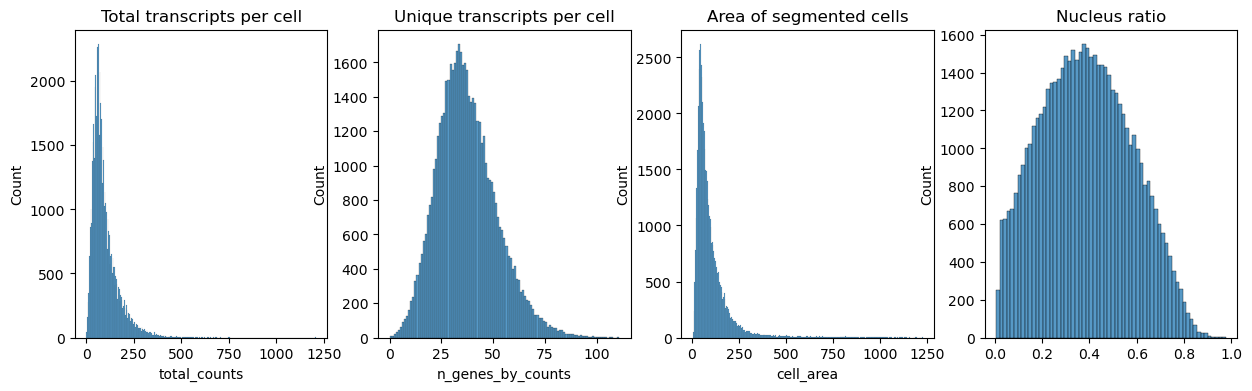

In [68]:
# Plotting QC metrics - again, also provided on the analysis_summary.html
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    subset_adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    subset_adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)


axs[2].set_title("Area of segmented cells")
sns.histplot(
    subset_adata.obs["cell_area"],
    kde=False,
    ax=axs[2],
)

axs[3].set_title("Nucleus ratio")
sns.histplot(
    subset_adata.obs["nucleus_area"] / subset_adata.obs["cell_area"],
    kde=False,
    ax=axs[3],
)

/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(0.0, 2800.0)

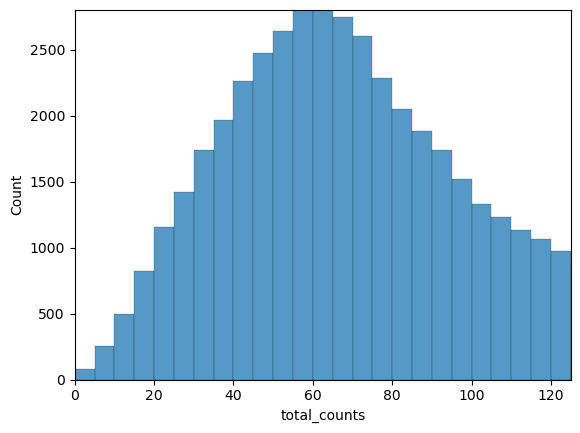

In [71]:
sns.histplot(
    subset_adata.obs["total_counts"],
    kde=False,
    binwidth=5)
    #ax=axs[0],)

plt.xlim(0, 125)
plt.ylim(0, 2800)

In [72]:
# Filtering cells/genes based on QC graph above. Filter criteria can be cell area, DAPI signal or minium of unique transcripts
sc.pp.filter_cells(subset_adata, min_counts=15) # The Xenium anlysis summary would help
sc.pp.filter_genes(subset_adata, min_cells=5) #min number of cells expresed required for a gene to pass filtering; min # of counts required for a gene to pass filtering. Using Xenium explorer to help

In [73]:
subset_adata # filter out ~4k cells, ~2.5%

AnnData object with n_obs × n_vars = 54017 × 314
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    obsm: 'spatial'

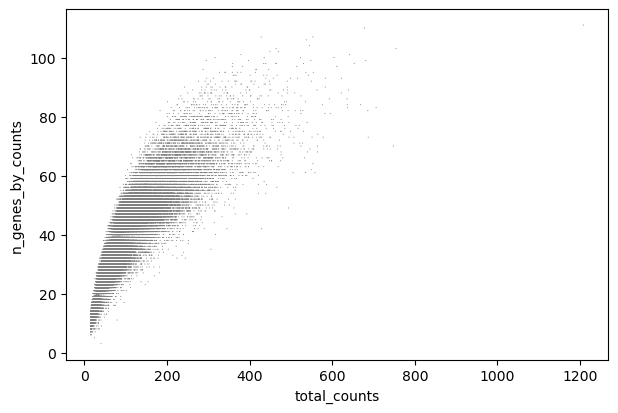

In [74]:
# Following scanpy preprocessing workflow https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html
sc.pl.scatter(subset_adata, x='total_counts', y='n_genes_by_counts') # check whether to remove more

In [75]:
# Normalisation using default setting
subset_adata.layers["counts"] = subset_adata.X.copy()
sc.pp.normalize_total(subset_adata, inplace=True)
sc.pp.log1p(subset_adata)

# scale the data for visualisation step later
subset_adata.layers['scaled'] = sc.pp.scale(subset_adata, copy=True).X

# PCA and UMAP
sc.pp.pca(subset_adata) #default = 50PCs

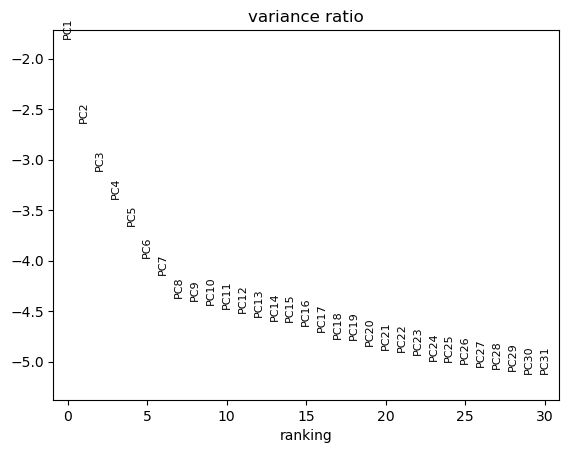

In [78]:
sc.pl.pca_variance_ratio(subset_adata, log=True)

In [79]:
# can read more about setting the parameter at https://umap-learn.readthedocs.io/en/latest/parameters.html
sc.pp.neighbors(subset_adata,
               n_neighbors =15) # n_neighbour default = 15, can set between 2-200, controls how UMAP balances local vs global structure in the data; small n-neigbours = focus more on local structure, 

In [80]:
sc.tl.umap(subset_adata)

In [81]:
# Clustering by leiden, using different resolutions
sc.tl.leiden(subset_adata, key_added = "leiden_1.0") # default resolution in 1.0
sc.tl.leiden(subset_adata, resolution = 1.5, key_added = "leiden_1.5")
sc.tl.leiden(subset_adata, resolution = 1.8, key_added = "leiden_1.8")

/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


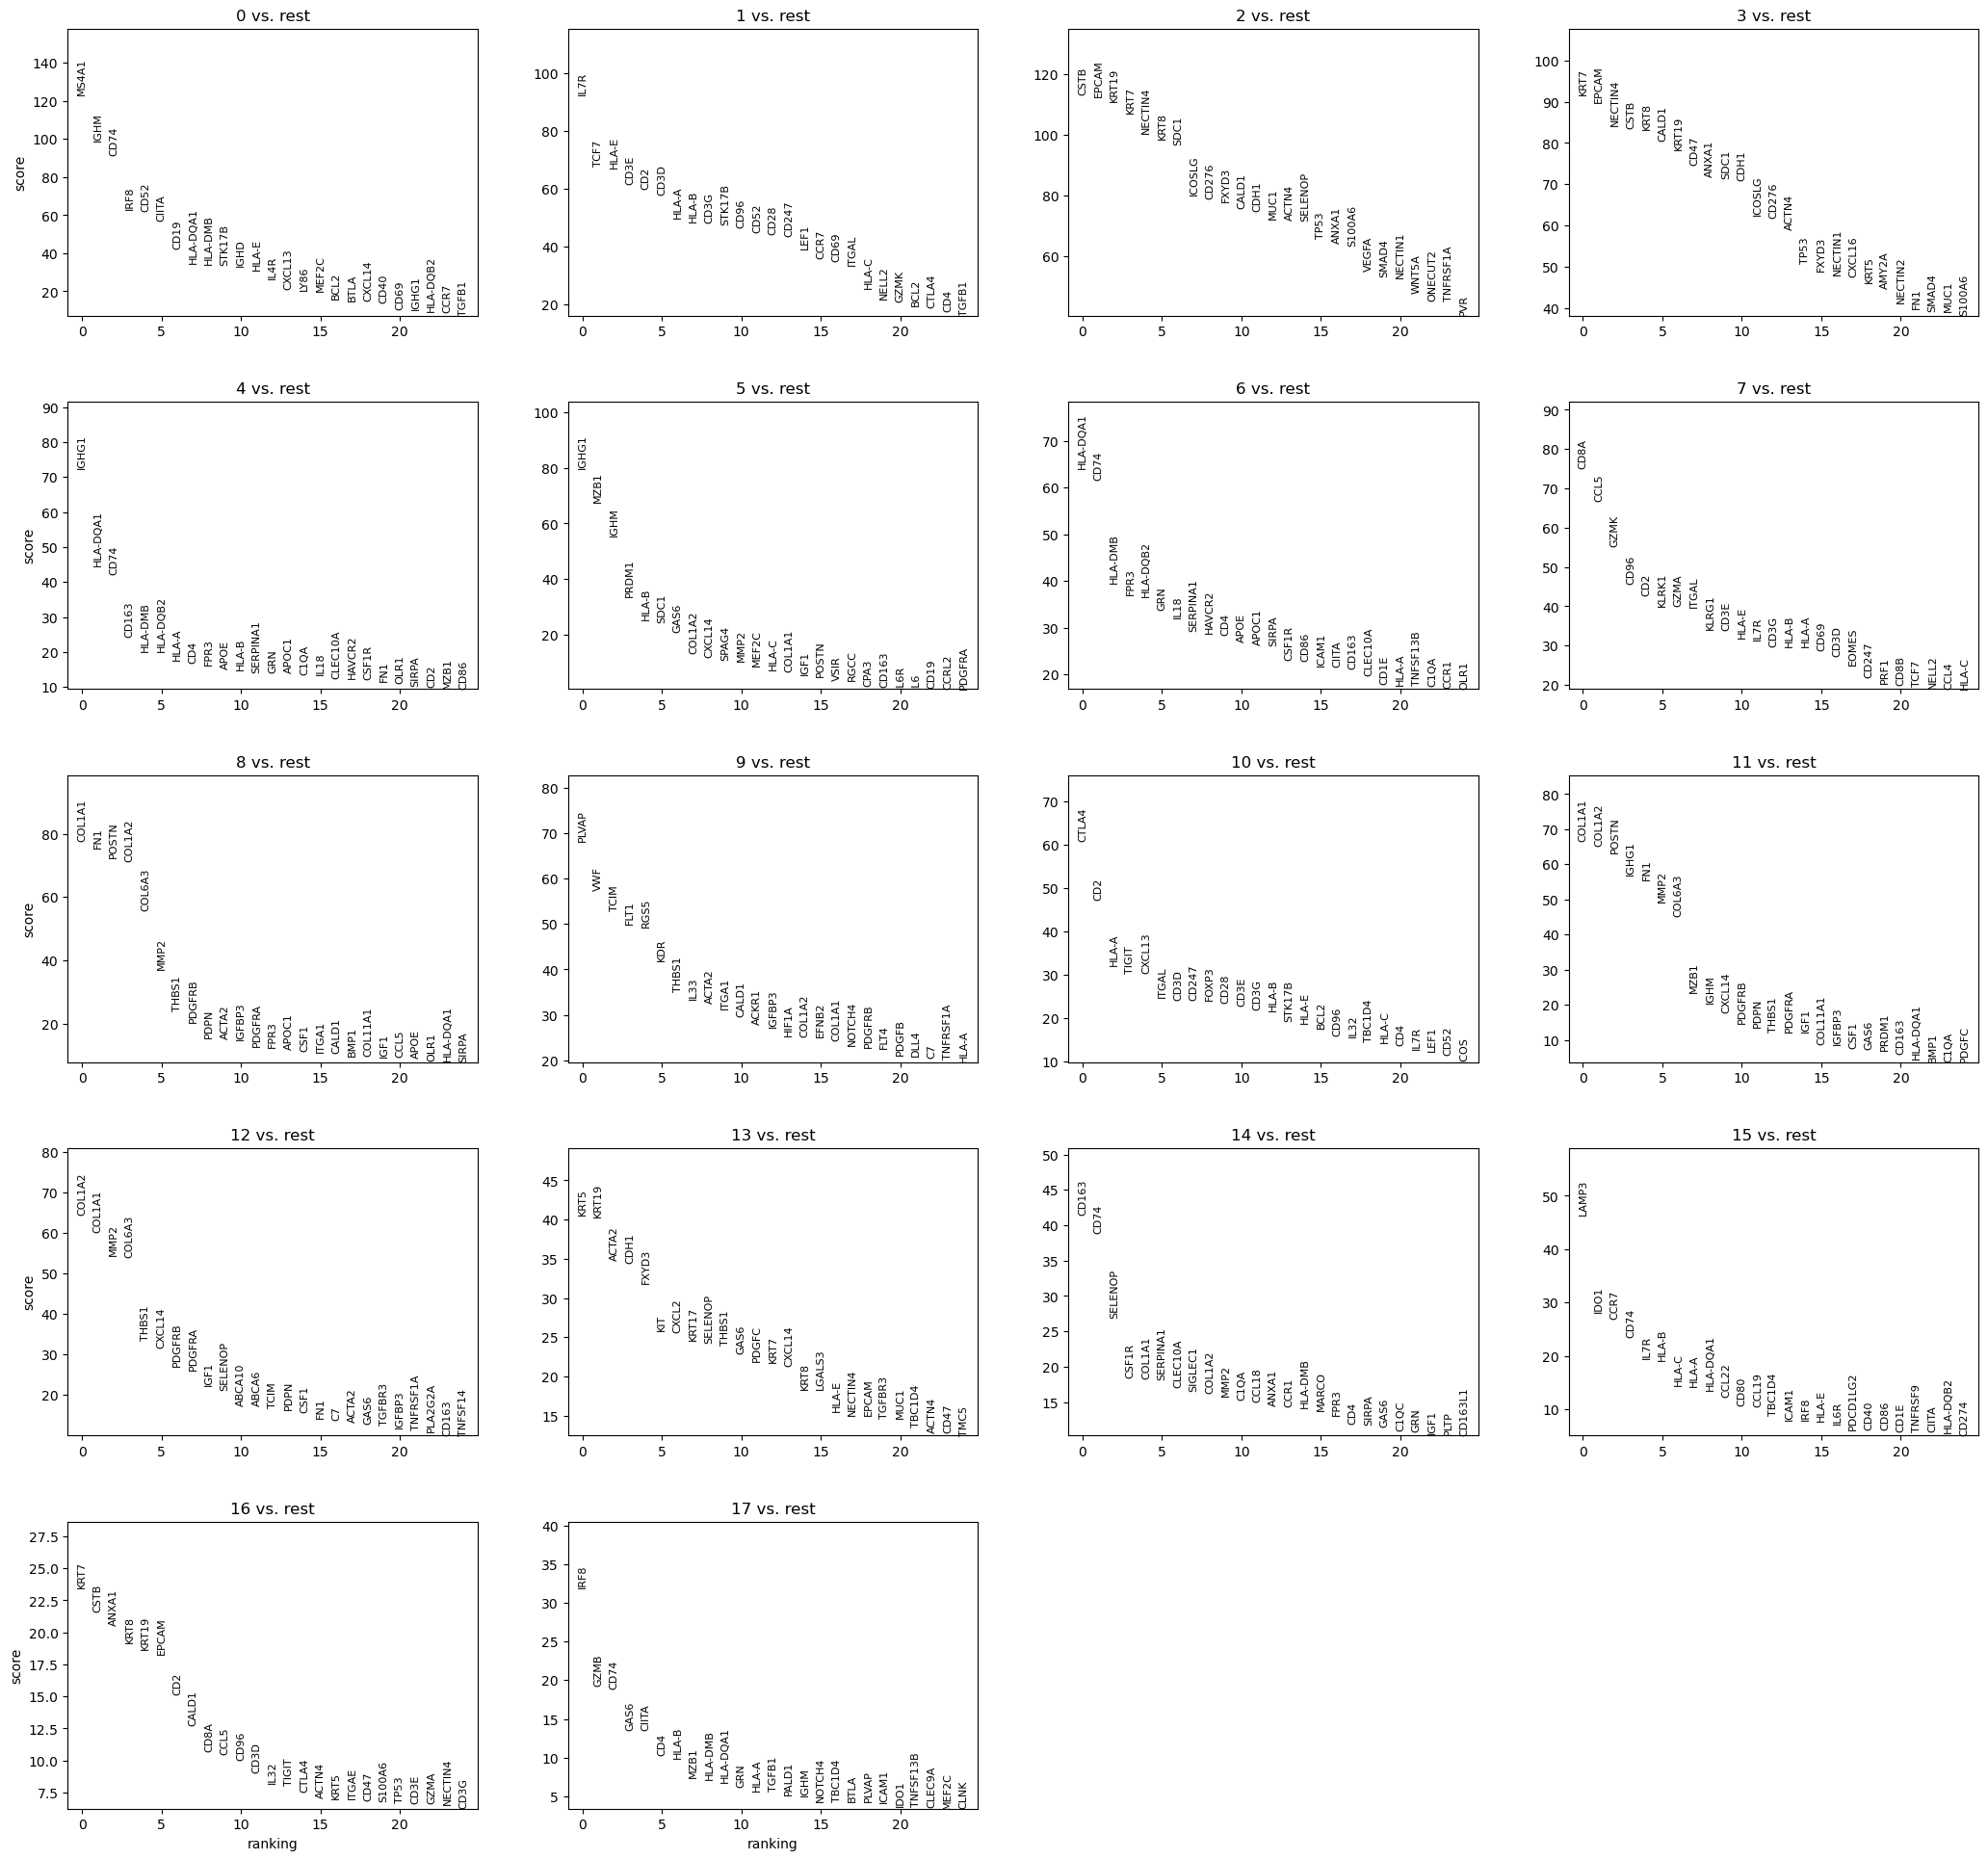

In [89]:
# Find Marker genes
sc.tl.rank_genes_groups(subset_adata, 'leiden_1.5', method='wilcoxon')
sc.pl.rank_genes_groups(subset_adata, n_genes=25, sharey=False)

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


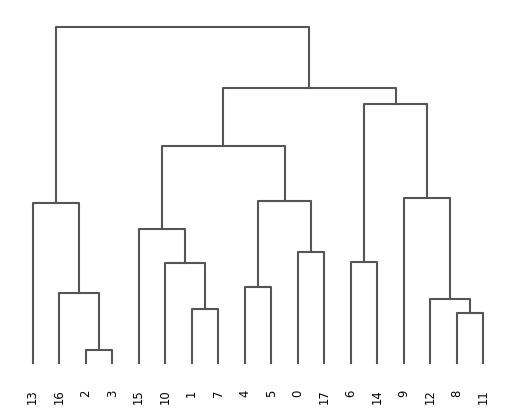

<Axes: >

In [90]:
# Running dendogram
sc.tl.dendrogram(subset_adata, groupby = "leiden_1.5")
sc.pl.dendrogram(subset_adata, groupby = "leiden_1.5")

In [8]:
# CLUSTER ANNOATION
cluster_anno = {
   "13": "Myoepithelial", 
    "16": "Malignant_epithelial", 
    "2": "Malignant_epithelial", 
    "3": "Malignant_epithelial", 
    "15": "Migratory DCs",
    "10": "CD2+_CTLA4+_TIGIT+",
    "1": "CD2+_IL7R+_TCF7+", 
    "7": "CD8A+_CCL5+_GZMK+",
    "4": "LAMs", 
    "5": "Plasma", 
    "0": "B", 
    "17": "pDCs", 
    "6": "LAMs", 
    "14": "Mac_SIGLEC1+",
    "9": "Endothelial", 
    "12": "FRCs",
    "8": "myCAFs", 
    "11": "myCAFs" 
}

In [9]:
subset_adata.obs["anno_revised"] = subset_adata.obs['leiden_1.5'].map(cluster_anno)
subset_adata.obs['leiden_1.5'].map(cluster_anno)

aaekbdpj-1         Myoepithelial
aaekdanj-1         Myoepithelial
aaekgcca-1         Myoepithelial
aaekjphj-1         Myoepithelial
aaekmpnl-1         Myoepithelial
                     ...        
npjhfobk-1                  LAMs
npjhhjea-1     CD8A+_CCL5+_GZMK+
npjhmnfi-1                Plasma
npjhnped-1                Plasma
npjholmf-1    CD2+_CTLA4+_TIGIT+
Name: leiden_1.5, Length: 54017, dtype: object

In [97]:
subset_adata.obs["anno"] = subset_adata.obs['leiden_1.5'].map(cluster_anno)
subset_adata.obs['leiden_1.5'].map(cluster_anno)

aaekbdpj-1         Myoepithelial
aaekdanj-1         Myoepithelial
aaekgcca-1         Myoepithelial
aaekjphj-1         Myoepithelial
aaekmpnl-1         Myoepithelial
                     ...        
npjhfobk-1                Plasma
npjhhjea-1     CD8A+_CCL5+_GZMK+
npjhmnfi-1                Plasma
npjhnped-1                Plasma
npjholmf-1    CD2+_CTLA4+_TIGIT+
Name: leiden_1.5, Length: 54017, dtype: object

In [99]:
genes = ['MS4A1','CLEC10A','CD8A','CD2','C1QA','KRT19','NGFR','ABCA6','ACTA2','EPCAM']

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


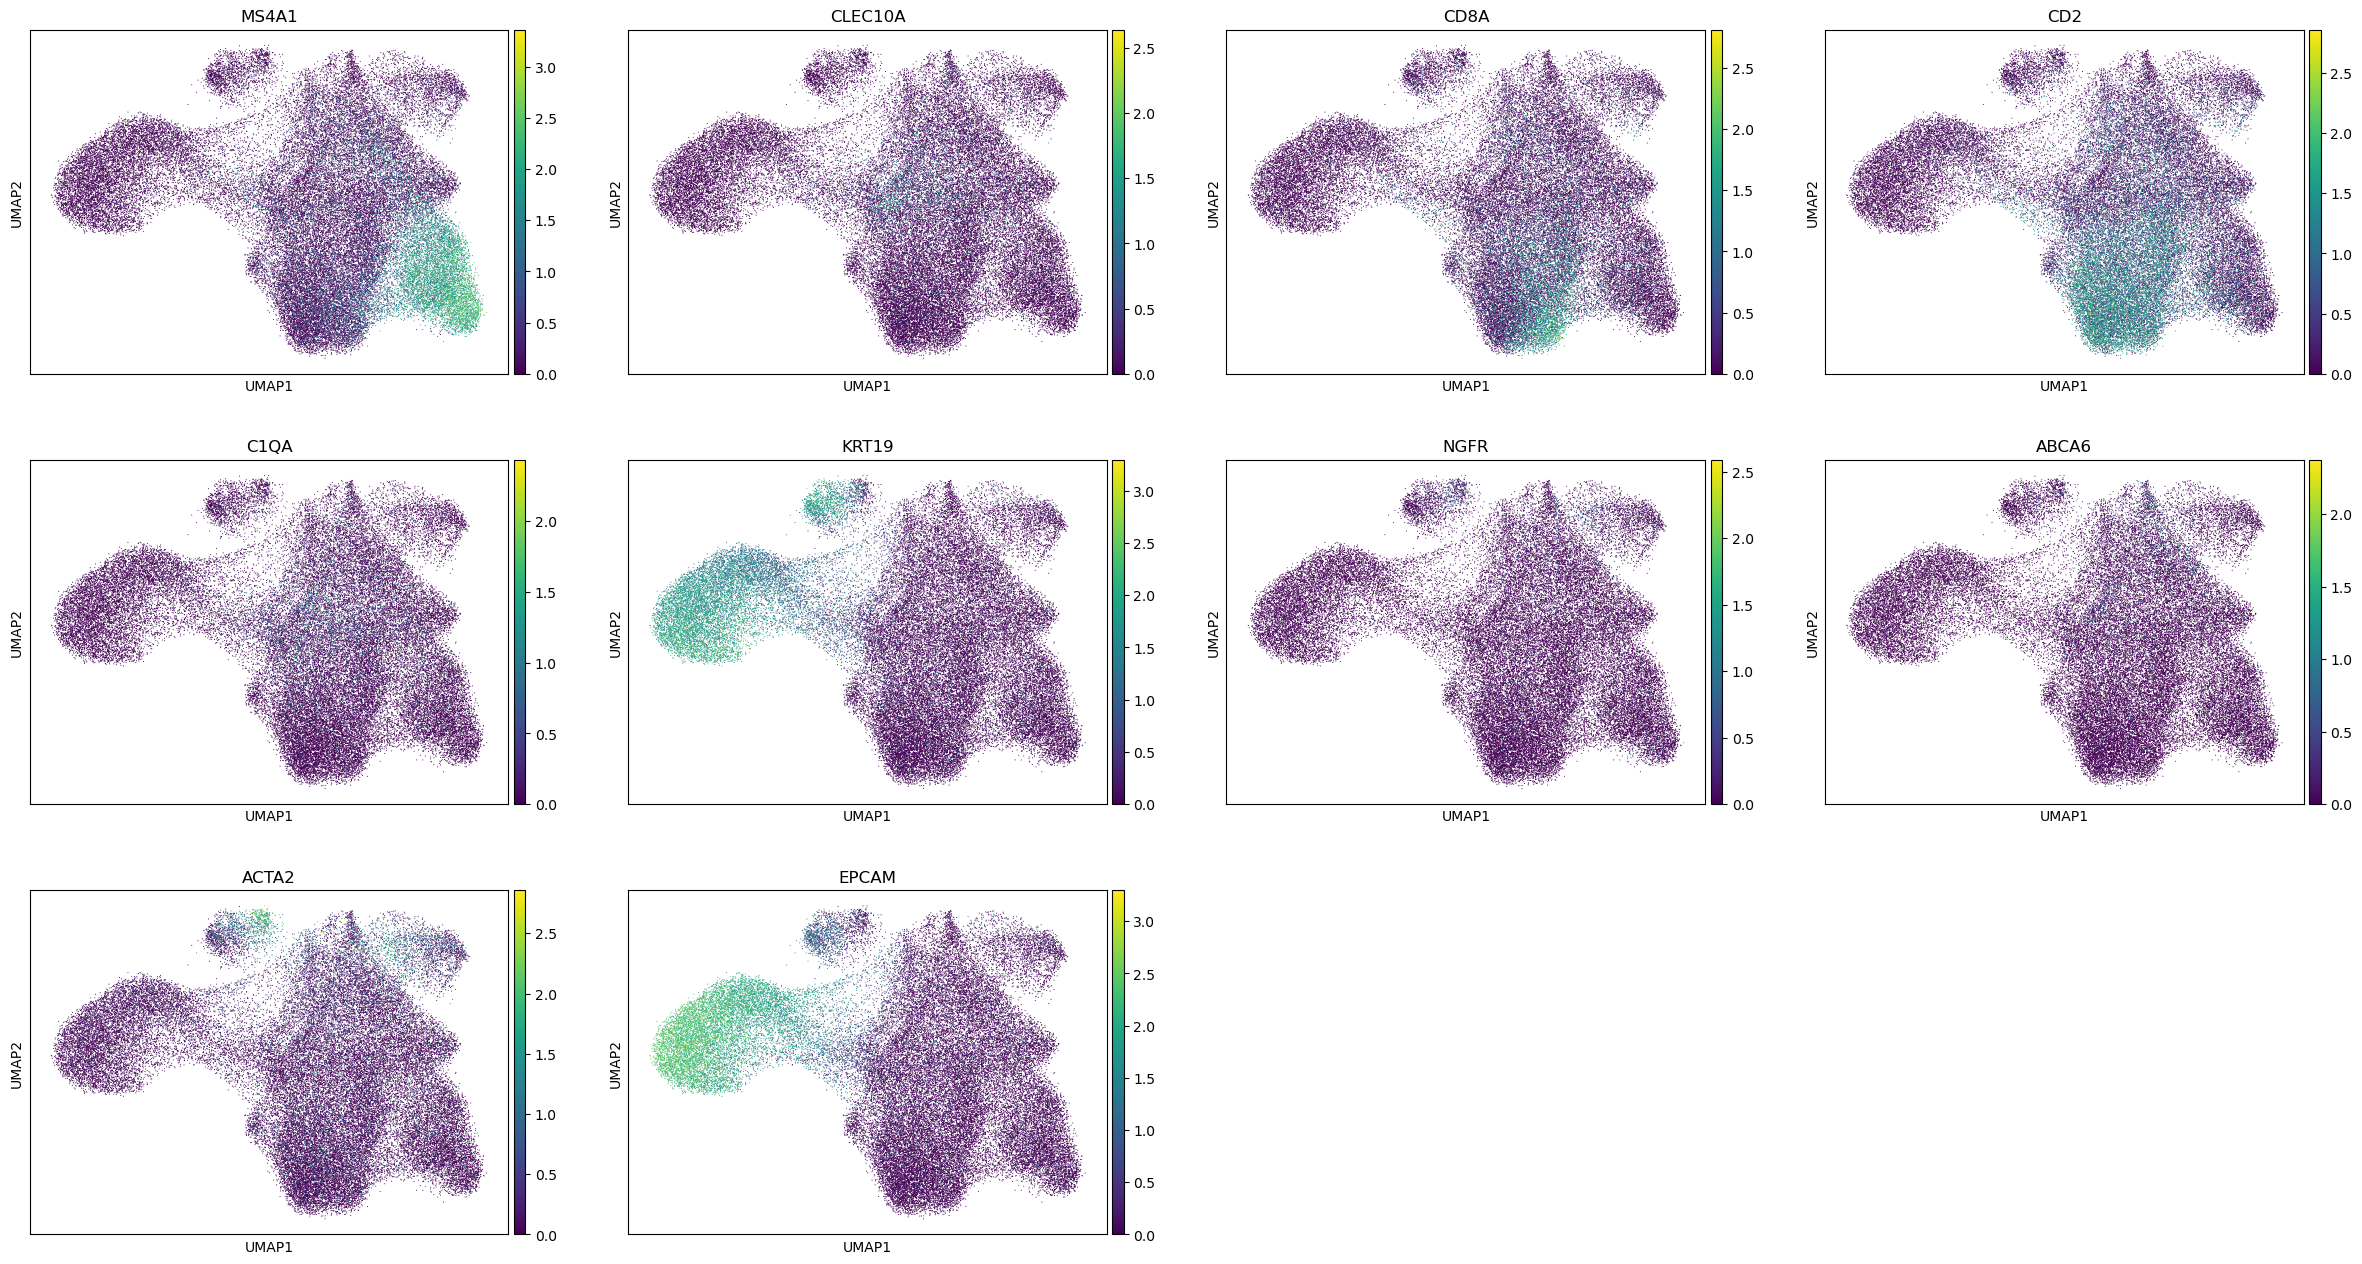

In [100]:
sc.pl.umap(subset_adata, color=genes)

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:747: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if c is not None and c in adata.obs and is_categorical_dtype(adata.obs[c]):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/homevol/huemail/.local/lib/python3.9/site-pa

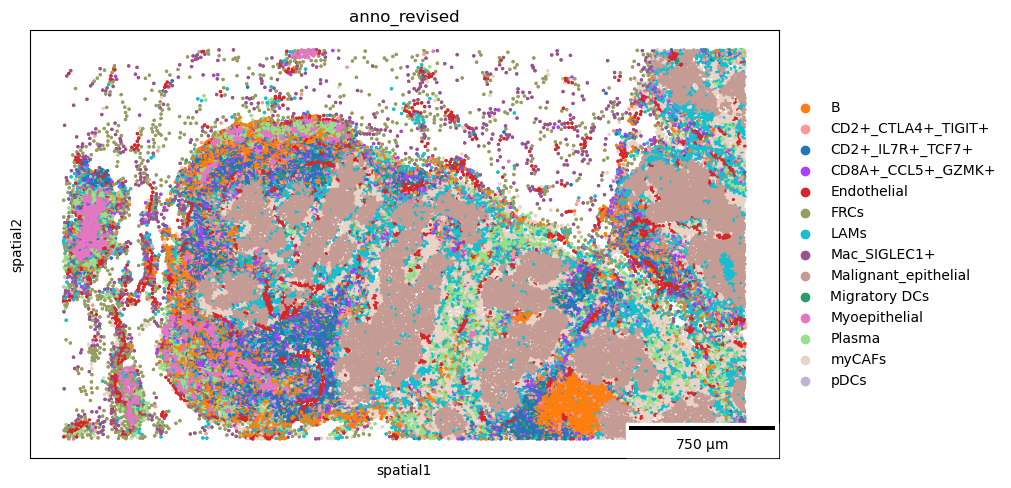

In [19]:
# Visualisation - at spatial context
sq.pl.spatial_scatter(
    subset_adata,
    size=8,
    library_id="spatial",
    shape=None,
    color=[
        "anno_revised",
    ],
    wspace=0.5, figsize=(10,10),
        scalebar_dx = 1.0,
    scalebar_kwargs={"scale_loc": "bottom", "location": "lower right"}, save = 'fig_6_TBNC.pdf'
)

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


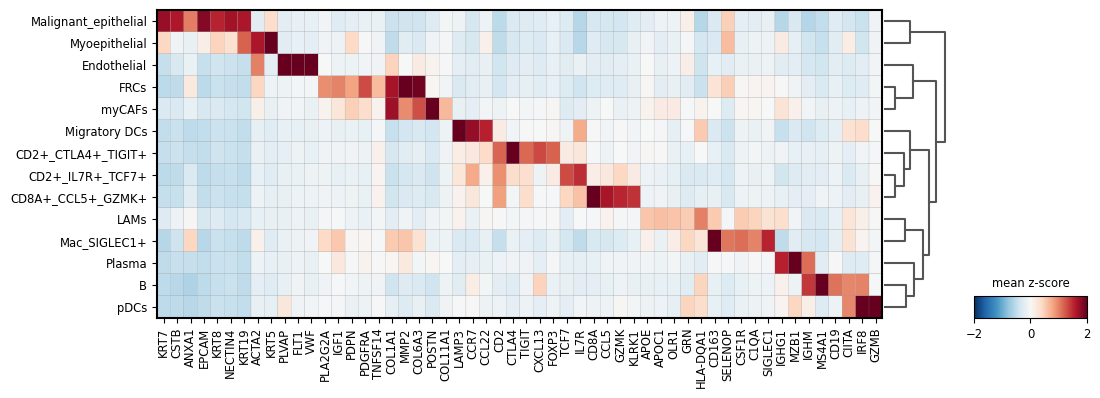

In [42]:
sc.pl.matrixplot(subset_adata, genes, groupby='anno_revised', dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',  figsize=(12, 4))

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


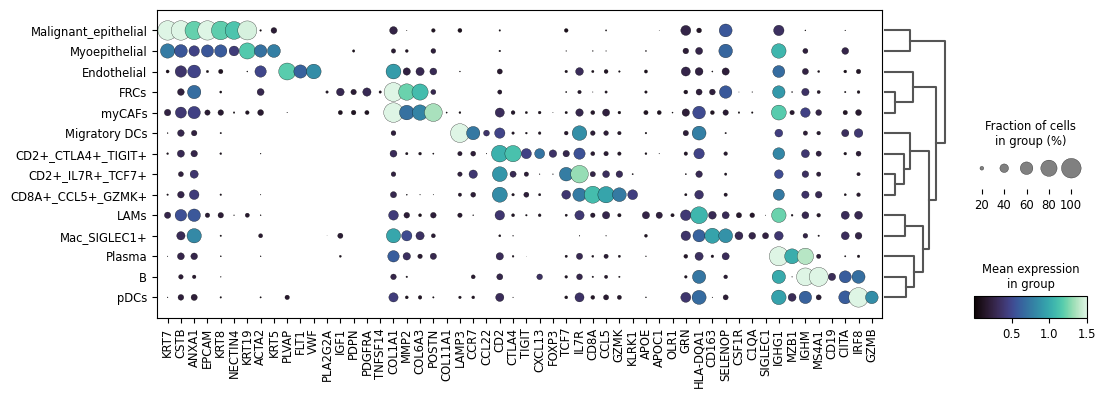

In [11]:
sc.pl.dotplot(subset_adata, var_names = genes , groupby='anno_revised', #swap_axes = True, 
              figsize=(12, 4), vmax=1.5, dot_min=0.1, cmap = 'mako',
             dendrogram=True, 
             save = 'Sfig6.pdf'
             )

In [7]:
genes = ["KRT7","CSTB","ANXA1","EPCAM","KRT8","NECTIN4",
         "KRT19","ACTA2","KRT5",
         'PLVAP','FLT1','VWF',
         'PLA2G2A','IGF1','PDPN','PDGFRA','TNFSF14',
         'COL1A1','MMP2','COL6A3','POSTN','COL11A1',
         'LAMP3','CCR7','CCL22',
         'CD2','CTLA4','TIGIT','CXCL13','FOXP3',
         'TCF7','IL7R',
         'CD8A','CCL5','GZMK','KLRK1',
         'APOE','APOC1','OLR1','GRN','HLA-DQA1',#'HLA-DMB',
         'CD163','SELENOP','CSF1R','C1QA','SIGLEC1',
         'IGHG1','MZB1',
         'IGHM','MS4A1','CD19',
         'CIITA','IRF8','GZMB']

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.93/s]
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/homevol/huemail/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and

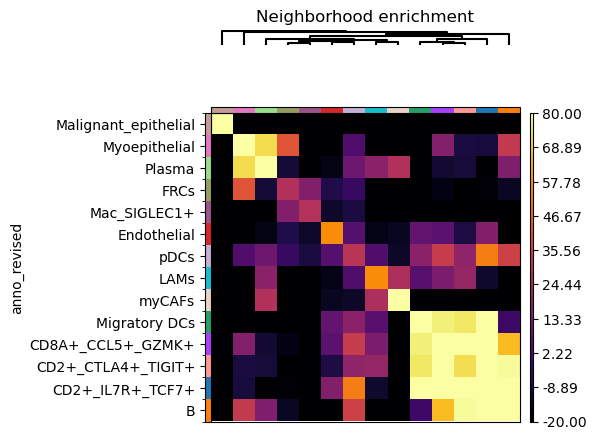

In [9]:
sq.gr.spatial_neighbors(subset_adata, coord_type="generic", spatial_key="spatial", radius=50) # can add radius and n_neighbour
sq.gr.nhood_enrichment(subset_adata, cluster_key="anno_revised", seed = 2323)
sq.pl.nhood_enrichment(
    subset_adata,
    cluster_key="anno_revised",
    method="average",
    cmap="inferno",
    vmin=-20,
    vmax=80,
    figsize=(4,4), 
)

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/homevol/huemail/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_utils.py:556: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, u

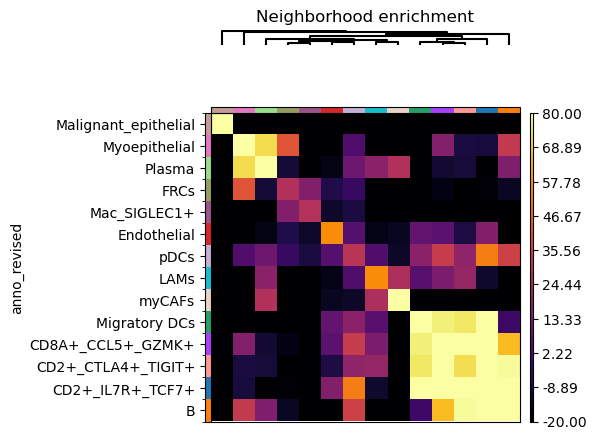

In [10]:
sq.pl.nhood_enrichment(
    subset_adata,
    cluster_key="anno_revised",
    method="average",
    cmap="inferno",
    vmin=-20,
    vmax=80,
    figsize=(4,4), save='tbnc_nhood.pdf'
)

In [116]:
# The Moran’s I global spatial auto-correlation statistics evaluates whether features (i.e. genes) shows a pattern that is clustered, dispersed or random in the tissue are under consideration.
sq.gr.spatial_neighbors(subset_adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    subset_adata,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.25/s]


In [119]:
subset_adata.uns["moranI"].head(40) # top genes that show strong spatial patterning

I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
EPCAM    0.843975        0.0  0.000006         0.0  0.009901  0.000019   
KRT7     0.772491        0.0  0.000006         0.0  0.009901  0.000015   
KRT19    0.768839        0.0  0.000006         0.0  0.009901  0.000015   
IGHG1    0.725300        0.0  0.000006         0.0  0.009901  0.000014   
NECTIN4  0.708609        0.0  0.000006         0.0  0.009901  0.000016   
CSTB     0.699865        0.0  0.000006         0.0  0.009901  0.000013   
KRT8     0.609309        0.0  0.000006         0.0  0.009901  0.000013   
CD74     0.605050        0.0  0.000006         0.0  0.009901  0.000012   
SDC1     0.597869        0.0  0.000006         0.0  0.009901  0.000012   
FN1      0.552276        0.0  0.000006         0.0  0.009901  0.000011   
IGHM     0.530234        0.0  0.000006         0.0  0.009901  0.000012   
COL1A1   0.529950        0.0  0.000006         0.0  0.009901  0.000008   
SPP1     0.525494        0.0  0.000006         0.0  0.009901  0.000013   
POSTN    0.515161        0.0  0.000006         0.0  0.009901  0.000010   
COL1A2   0.502553        0.0  0.000006         0.0  0.009901  0.000010   
CDH1     0.479690        0.0  0.000006         0.0  0.009901  0.000009   
FXYD3    0.465468        0.0  0.000006         0.0  0.009901  0.000010   
CXCL13   0.450061        0.0  0.000006         0.0  0.009901  0.000010   
CALD1    0.444705        0.0  0.000006         0.0  0.009901  0.000014   
MUC1     0.441023        0.0  0.000006         0.0  0.009901  0.000010   
MS4A1    0.438019        0.0  0.000006         0.0  0.009901  0.000010   
KRT5     0.429957        0.0  0.000006         0.0  0.009901  0.000008   
CHIT1    0.414936        0.0  0.000006         0.0  0.009901  0.000010   
VWF      0.405154        0.0  0.000006         0.0  0.009901  0.000010   
CD276    0.404063        0.0  0.000006         0.0  0.009901  0.000012   
ANXA1    0.401710        0.0  0.000006         0.0  0.009901  0.000009   
MMP2     0.399312        0.0  0.000006         0.0  0.009901  0.000008   
PLVAP    0.397901        0.0  0.000006         0.0  0.009901  0.000009   
ICOSLG   0.382342        0.0  0.000006         0.0  0.009901  0.000009   
CCL22    0.377360        0.0  0.000006         0.0  0.009901  0.000006   
SELENOP  0.371723        0.0  0.000006         0.0  0.009901  0.000009   
CXCL14   0.366960        0.0  0.000006         0.0  0.009901  0.000009   
HLA-B    0.366397        0.0  0.000006         0.0  0.009901  0.000009   
IL7R     0.365560        0.0  0.000006         0.0  0.009901  0.000008   
MZB1     0.347389        0.0  0.000006         0.0  0.009901  0.000007   
COL6A3   0.332250        0.0  0.000006         0.0  0.009901  0.000007   
LAMP3    0.330302        0.0  0.000006         0.0  0.009901  0.000007   
RGS5     0.318833        0.0  0.000006         0.0  0.009901  0.000006   
THBS1    0.318723        0.0  0.000006         0.0  0.009901  0.000006   
RGS13    0.312917        0.0  0.000006         0.0  0.009901  0.000007   

         pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
EPCAM                 0.0                0.0         0.010795  
KRT7                  0.0                0.0         0.010795  
KRT19                 0.0                0.0         0.010795  
IGHG1                 0.0                0.0         0.010795  
NECTIN4               0.0                0.0         0.010795  
CSTB                  0.0                0.0         0.010795  
KRT8                  0.0                0.0         0.010795  
CD74                  0.0                0.0         0.010795  
SDC1                  0.0                0.0         0.010795  
FN1                   0.0                0.0         0.010795  
IGHM                  0.0                0.0         0.010795  
COL1A1                0.0                0.0         0.010795  
SPP1                  0.0                0.0         0.010795  
POSTN                 0.0                0.0         0.010795  
COL1A2               

In [47]:
TLS = subset_adata[subset_adata.obs['anno_revised'].isin(['B', 'CD2+_CTLA4+_TIGIT+', 'CD2+_IL7R+_TCF7+', 'CD8A+_CCL5+_GZMK+',
       'Endothelial', 'FRCs', 'Mac_SIGLEC1+', 'Migratory DCs', 'Plasma'])]

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:161: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = dat


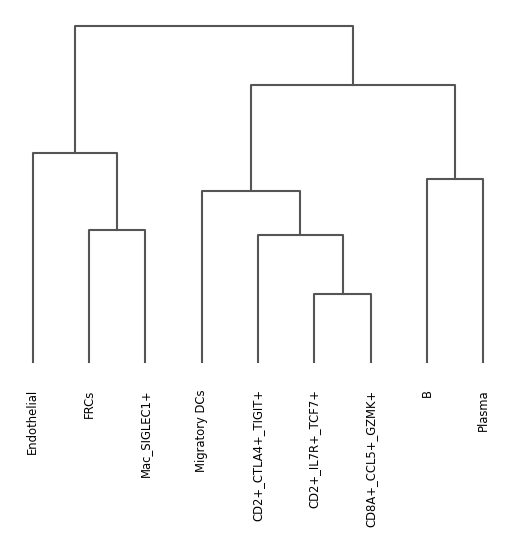

<Axes: >

In [48]:
# Running dendogram
sc.tl.dendrogram(TLS, groupby = "anno_revised")
sc.pl.dendrogram(TLS, groupby = "anno_revised")

In [49]:
TLS_cytokines = ['CXCL13','CCL19','CCL21','CCL22', 'TNFSF14',# TLS-cytokines
                 'ICAM1',
                 'CD80','CD274','CD28',#'NECTIN2',#'CD40','CD40LG',
                 'CCL5','PRF1',
                 'TIGIT','CTLA4','HAVCR2',
                   'SIGLEC1','MERTK','C1QA','C1QC',
                    'MZB1','VWF', 'IL6',
                   'PDGFRA','CXCL2','CXCL14','PLA2G2A','IGF1', 'CSF1','PDPN','HAS1']

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


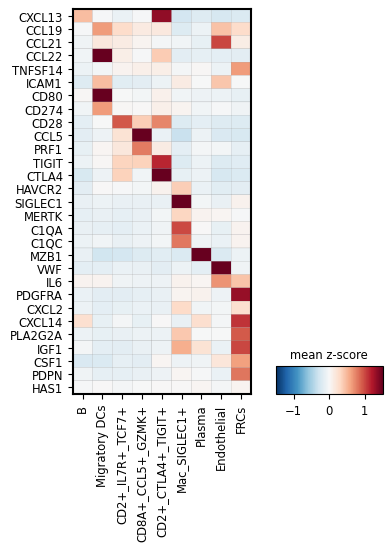

In [52]:
sc.pl.matrixplot(TLS, TLS_cytokines, groupby='anno_revised', dendrogram=False,swap_axes = True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-1.5, vmax=1.5, 
                 #cmap = 'viridis',
                 cmap='RdBu_r',  
                 categories_order = ['B',  'Migratory DCs','CD2+_IL7R+_TCF7+', 'CD8A+_CCL5+_GZMK+','CD2+_CTLA4+_TIGIT+', 
                  'Mac_SIGLEC1+','Plasma', 'Endothelial', 'FRCs'],
                 figsize=(4,5), 
                 save='BreastTLS_cytokine.pdf'
                )

In [53]:
pd.DataFrame(subset_adata.uns['anno_revised_nhood_enrichment']['zscore']) #50micron

0           1           2           3          4          5   \
0   343.371269   78.578650  101.262131   64.715606 -19.683387 -13.511299   
1    78.578650   71.700711  114.695230   83.574931  -8.402102 -25.656691   
2   101.262131  114.695230  257.084299  179.494391  15.674015 -18.784421   
3    64.715606   83.574931  179.494391   86.026057   6.516286 -16.537084   
4   -19.683387   -8.402102   15.674015    6.516286  54.962629  -7.253636   
5   -13.511299  -25.656691  -18.784421  -16.537084  -7.253636  27.589540   
6   -34.106494   20.310152  -12.004135   14.146941 -15.861348 -43.798951   
7   -30.849929  -29.582164  -38.422878  -27.174294 -12.507566  15.711991   
8  -143.093461  -76.917627 -136.490960  -99.366538 -69.144824 -87.230146   
9    -0.824939   73.696631  157.344866   75.442421   7.890913 -22.804822   
10   31.747923   -8.765615   -9.475449   16.151933 -20.554042  41.024550   
11   14.992617  -10.182951  -38.233291  -11.365359 -16.228247 -10.380778   
12  -73.532004  -22.082992  -68.260607  -36.725938 -13.808853 -53.567117   
13   34.829196   19.102958   51.830799   32.924273   4.838735  -2.119783   

           6          7           8           9           10          11  \
0  -34.106494 -30.849929 -143.093461   -0.824939   31.747923   14.992617   
1   20.310152 -29.582164  -76.917627   73.696631   -8.765615  -10.182951   
2  -12.004135 -38.422878 -136.490960  157.344866   -9.475449  -38.233291   
3   14.146941 -27.174294  -99.366538   75.442421   16.151933  -11.365359   
4  -15.861348 -12.507566  -69.144824    7.890913  -20.554042  -16.228247   
5  -43.798951  15.711991  -87.230146  -22.804822   41.024550  -10.380778   
6   54.798619 -39.919353  -87.586619    5.767327  -37.046081   18.176868   
7  -39.919353  27.796735  -73.722532  -24.757039  -19.681679  -30.761065   
8  -87.586619 -73.722532  181.720639  -50.289254  -79.198491 -104.807272   
9    5.767327 -24.757039  -50.289254  103.162369  -28.933489  -31.859187   
10 -37.046081 -19.681679  -79.198491  -28.933489  399.565272   71.101305   
11  18.176868 -30.761065 -104.807272  -31.859187   71.101305  131.091512   
12  26.330866 -43.834177  -63.652320  -26.402999  -64.690299   27.286237   
13   3.636585  -8.706496  -36.342016   18.151775    3.491752   10.573726   

           12         13  
0  -73.532004  34.829196  
1  -22.082992  19.102958  
2  -68.260607  51.830799  
3  -36.725938  32.924273  
4  -13.808853   4.838735  
5  -53.567117  -2.119783  
6   26.330866   3.636585  
7  -43.834177  -8.706496  
8  -63.652320 -36.342016  
9  -26.402999  18.151775  
10 -64.690299   3.491752  
11  27.286237  10.573726  
12  81.926862 -12.739565  
13 -12.739565  29.435716

In [54]:
subset_adata.obs['anno_revised'].cat.categories # use this to label the column and row again

Index(['B', 'CD2+_CTLA4+_TIGIT+', 'CD2+_IL7R+_TCF7+', 'CD8A+_CCL5+_GZMK+',
       'Endothelial', 'FRCs', 'LAMs', 'Mac_SIGLEC1+', 'Malignant_epithelial',
       'Migratory DCs', 'Myoepithelial', 'Plasma', 'myCAFs', 'pDCs'],
      dtype='object')

In [55]:
from pathlib import Path  
df = pd.DataFrame(subset_adata.uns['anno_revised_nhood_enrichment']['zscore'])
df.columns = ['B', 'CD2+_CTLA4+_TIGIT+', 'CD2+_IL7R+_TCF7+', 'CD8A+_CCL5+_GZMK+',
       'Endothelial', 'FRCs', 'LAMs', 'Mac_SIGLEC1+', 'Malignant_epithelial',
       'Migratory DCs', 'Myoepithelial', 'Plasma', 'myCAFs', 'pDCs']
df.index = ['B', 'CD2+_CTLA4+_TIGIT+', 'CD2+_IL7R+_TCF7+', 'CD8A+_CCL5+_GZMK+',
       'Endothelial', 'FRCs', 'LAMs', 'Mac_SIGLEC1+', 'Malignant_epithelial',
       'Migratory DCs', 'Myoepithelial', 'Plasma', 'myCAFs', 'pDCs']

In [56]:
filepath = Path("../NhoodEnrichment/BreastTLS/P4754_50um.csv")  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath) 